# Linear diffusion of a hot pipe

- Using the adv_diff solver.
- No advection as the velocity field is not updated (and set to 0).
- Benchmark comparison between 1D analytical solution and 2D UW numerical model.


In [1]:
from petsc4py import PETSc
import underworld3 as uw
from underworld3.systems import Stokes
import numpy as np
import sympy
from mpi4py import MPI

In [2]:
import math

In [3]:
if uw.mpi.size == 1:
    import matplotlib.pyplot as plt

In [4]:
# %%
sys = PETSc.Sys()
sys.pushErrorHandler("traceback")

In [5]:
# Set the resolution.
res = 32

In [6]:
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

In [7]:
pipe_thickness = 0.4  ###

In [8]:
mesh = uw.meshing.StructuredQuadBox(
    elementRes=(int(res), int(res)), minCoords=(xmin, ymin), maxCoords=(xmax, ymax)
)

In [9]:
# Set some values of the system
k = 1.0 # diffusive constant

tmin = 0.5 # temp min
tmax = 1.0 # temp max

In [10]:
# Create an adv
v = uw.discretisation.MeshVariable("U", mesh, mesh.dim, degree=2)
T = uw.discretisation.MeshVariable("T", mesh, 1, degree=1)

#### Create the advDiff solver

In [11]:
adv_diff = uw.systems.AdvDiffusionSLCN(
    mesh,
    u_Field=T,
    V_Field=v,
    solver_name="adv_diff",
)

In [12]:
adv_diff.constitutive_model = uw.systems.constitutive_models.DiffusionModel(mesh.dim)
adv_diff.constitutive_model.Parameters.diffusivity = k

In [13]:
# %%
### fix temp of top and bottom walls
adv_diff.add_dirichlet_bc(0.5, "Bottom")
adv_diff.add_dirichlet_bc(0.5, "Top")

In [14]:
# %%
maxY = mesh.data[:, 1].max()
minY = mesh.data[:, 1].min()

In [15]:
with mesh.access(T):
    T.data[...] = tmin

    pipePosition = ((maxY - minY) - pipe_thickness) / 2.0

    T.data[
        (mesh.data[:, 1] >= (mesh.data[:, 1].min() + pipePosition))
        & (mesh.data[:, 1] <= (mesh.data[:, 1].max() - pipePosition))
    ] = tmax

In [16]:
# %%
def plot_fig():
    if uw.mpi.size == 1:

        import numpy as np
        import pyvista as pv
        import vtk

        pv.global_theme.background = "white"
        pv.global_theme.window_size = [750, 250]
        pv.global_theme.antialiasing = True
        pv.global_theme.jupyter_backend = "panel"
        pv.global_theme.smooth_shading = True

        # pv.start_xvfb()
        mesh.vtk("tmpMsh.vtk")
        # mesh.vtk("ignore_periodic_mesh.vtk")
        pvmesh = pv.read("tmpMsh.vtk")

        # pvmesh.point_data["S"]  = uw.function.evaluate(s_soln.fn, meshbox.data)

        with mesh.access():
            vsol = v.data.copy()
            pvmesh["T"] = T.data.copy()

        arrow_loc = np.zeros((v.coords.shape[0], 3))
        arrow_loc[:, 0:2] = v.coords[...]

        arrow_length = np.zeros((v.coords.shape[0], 3))
        arrow_length[:, 0:2] = vsol[...]

        pl = pv.Plotter()

        pl.add_mesh(pvmesh, "Black", "wireframe")

        # pvmesh.point_data["rho"] = uw.function.evaluate(density, mesh.data)

        pl.add_mesh(
            pvmesh,
            cmap="coolwarm",
            edge_color="Black",
            show_edges=True,
            scalars="T",
            use_transparency=False,
            opacity=0.95,
        )

        # pl.add_mesh(pvmesh, cmap="coolwarm", edge_color="Black", show_edges=True, scalars="S",
        #               use_transparency=False, opacity=0.5)

        # pl.add_mesh(
        #     point_cloud,
        #     cmap="coolwarm",
        #     edge_color="Black",
        #     show_edges=False,
        #     scalars="M",
        #     use_transparency=False,
        #     opacity=0.95,
        # )

        pl.add_arrows(arrow_loc, arrow_length, mag=5.0, opacity=0.5)
        # pl.add_arrows(arrow_loc2, arrow_length2, mag=1.0e-1)

        # pl.add_points(pdata)

        pl.show(cpos="xy")

        # return vsol

In [17]:
plot_fig()

/var/folders/0_/fbgfh0h563nf0y4g61d675gs665gb7/T/ipykernel_61239/2988534583.py:12: PyVistaDeprecationWarning: `panel` backend is deprecated and is planned for future removal.
  pv.global_theme.jupyter_backend = "panel"


BokehModel(combine_events=True, render_bundle={'docs_json': {'eef803fe-ce5b-4e32-a9e1-461d28a8c35e': {'version…

##### Vertical profile across the centre of the box

In [18]:
### y coords to sample
sample_y = np.arange(
    mesh.data[:, 1].min(), mesh.data[:, 1].max(), mesh.get_min_radius()
)  ### Vertical profile

In [19]:
### x coords to sample
sample_x = np.zeros_like(sample_y)  ### LHS of box

In [20]:
sample_points = np.empty((sample_x.shape[0], 2))
sample_points[:, 0] = sample_x
sample_points[:, 1] = sample_y

In [21]:
t0 = uw.function.evaluate(adv_diff.u.fn, sample_points)

In [22]:
### estimate the timestep based on diffusion only
dt = mesh.get_min_radius() ** 2 / k  ### dt = length squared / diffusivity
print(f"dt: {dt}")

dt: 0.0002441406249966624


In [23]:
# %%
def diffusion_1D(sample_points, tempProfile, k, model_dt):
    x = sample_points
    T = tempProfile

    dx = sample_points[1] - sample_points[0]

    dt = 0.5 * (dx**2 / k)

    """ max time of model """
    total_time = model_dt

    """ get min of 1D and 2D model """
    time_1DModel = min(model_dt, dt)

    """ determine number of its """
    nts = math.ceil(total_time / time_1DModel)

    """ get dt of 1D model """
    final_dt = total_time / nts

    for i in range(nts):
        qT = -k * np.diff(T) / dx
        dTdt = -np.diff(qT) / dx
        T[1:-1] += dTdt * final_dt

    return T

In [24]:
### get the initial temp profile
tempData = uw.function.evaluate(adv_diff.u.fn, sample_points)

In [25]:
step = 0
time = 0.0

In [26]:
nsteps = 21

Step:   0, time: 0.00000


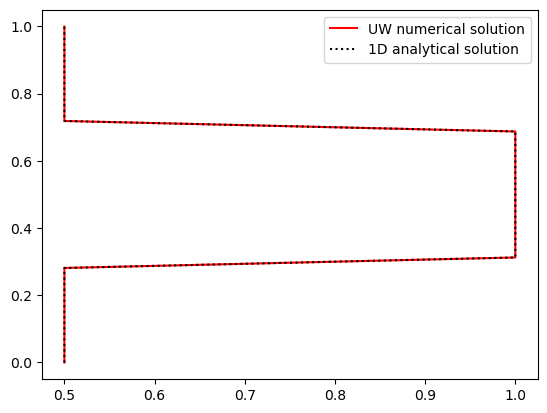

0.0002441406249966624 0.0002441406249966624


/Users/jgra0019/Documents/codes/uw3-dev/underworld3/underworld3/systems/solvers.py:1078: RuntimeWarning: divide by zero encountered in scalar divide
  dt_adv = min_dx / max_magvel_glob


  0 SNES Function norm 93.2487 
  1 SNES Function norm 0.00186935 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
Step:   1, time: 0.00024
0.0002441406249966624 0.0002441406249966624
  0 SNES Function norm 93.0295 
  1 SNES Function norm 0.00172007 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
Step:   2, time: 0.00049
0.0002441406249966624 0.0002441406249966624
  0 SNES Function norm 92.8601 
  1 SNES Function norm 0.00162438 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
Step:   3, time: 0.00073
0.0002441406249966624 0.0002441406249966624
  0 SNES Function norm 92.7166 
  1 SNES Function norm 0.00156224 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
Step:   4, time: 0.00098
0.0002441406249966624 0.0002441406249966624
  0 SNES Function norm 92.5896 
  1 SNES Function norm 0.00151688 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATI

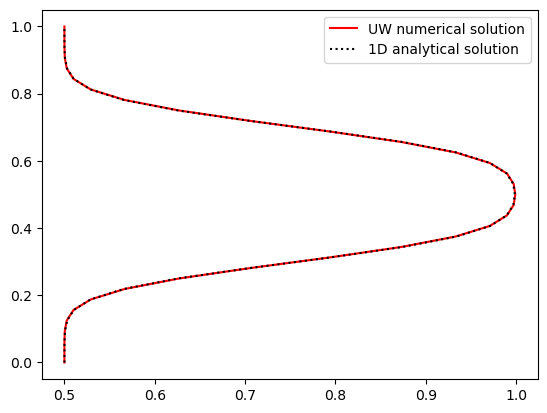

0.0002441406249966624 0.0002441406249966624
  0 SNES Function norm 92.0043 
  1 SNES Function norm 0.00136565 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
Step:  11, time: 0.00269
0.0002441406249966624 0.0002441406249966624
  0 SNES Function norm 91.924 
  1 SNES Function norm 0.00134835 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
Step:  12, time: 0.00293
0.0002441406249966624 0.0002441406249966624
  0 SNES Function norm 91.8469 
  1 SNES Function norm 0.00133221 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
Step:  13, time: 0.00317
0.0002441406249966624 0.0002441406249966624
  0 SNES Function norm 91.7726 
  1 SNES Function norm 0.0013171 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
Step:  14, time: 0.00342
0.0002441406249966624 0.0002441406249966624
  0 SNES Function norm 91.7007 
  1 SNES Function norm 0.00130289 
Nonlinear adv_diff_ sol

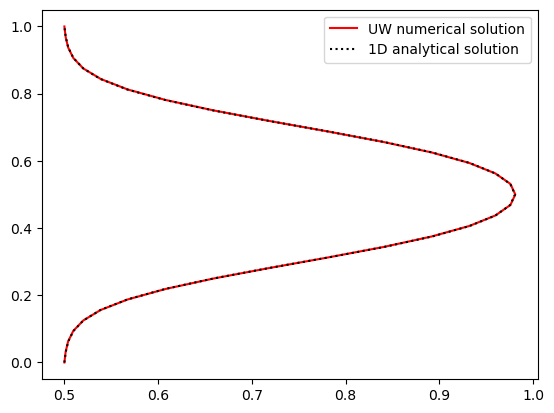

0.0002441406249966624 0.0002441406249966624
  0 SNES Function norm 91.3086 
  1 SNES Function norm 0.00123217 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1


In [27]:
while step < nsteps:
    ### print some stuff
    if uw.mpi.rank == 0:
        print(f"Step: {str(step).rjust(3)}, time: {time:6.5f}")

    ### 1D profile from underworld
    t1 = uw.function.evaluate(adv_diff.u.fn, sample_points)

    if uw.mpi.size == 1 and step % 10 == 0:
        """compare 1D and 2D models"""
        plt.figure()
        ### profile from UW
        plt.plot(t1, sample_points[:, 1], ls="-", c="red", label="UW numerical solution")
        ### numerical solution
        plt.plot(tempData, sample_points[:, 1], ls=":", c="k", label="1D analytical solution")
        plt.legend()
        plt.show()

    ### 1D diffusion
    tempData = diffusion_1D(
        sample_points=sample_points[:, 1], tempProfile=tempData, k=k, model_dt=dt
    )
    
    dt0 = adv_diff.estimate_dt()
    
    dt1 = mesh.get_min_radius() ** 2 / k
    
    print(dt0, dt1)
    
    dt = adv_diff.estimate_dt()
    
    ### diffuse through underworld
    adv_diff.solve(timestep=dt)

    step += 1
    time += dt

In [28]:
with mesh.access(v):
    print(v.data[:, 0].max())
    print(v.data[:, 0].min())

0.0
0.0


: 